# EBLR

In [1]:
from lineartree import LinearBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import pandas as pd
from joblib import dump
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [3]:
import sys
sys.path.append('F:\\Users\\Manuel García Plaza\\Desktop\\TFG\\')

In [4]:
from notebooks.utils.regression_metrics import regression

In [2]:
train =  pd.read_parquet('../../../data/model_input/train_sets/electricity_transformer.parquet')
validation =  pd.read_parquet('../../../data/model_input/validation_sets/electricity_transformer.parquet')

In [3]:
y_train = train.OT_next
X_train = train.drop(columns=['date', 'OT_next'])

In [4]:
y_validation = validation.OT_next
X_validation = validation.drop(columns=['date', 'OT_next'])

In [5]:
scaler = StandardScaler().fit(X_train)

In [6]:
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

In [10]:
max_depth = [1, 2, 3]
n_est = [1, 2, 3, 4, 5]
base_est =  [LinearRegression(), Ridge(), Lasso()]
loss = ['linear', 'square']

In [11]:
models_list = []
for n in n_est:
    for i in max_depth:
        for est in base_est:
            for l in loss:
                models_list.append(LinearBoostRegressor(base_estimator=est, n_estimators=n, max_depth=i, loss=l))

In [15]:
names_list = []
for n in n_est:
    for depth in max_depth:
        for est in base_est:
            for l in loss:
                if isinstance(est, LinearRegression):
                    name = f'EBLR_{depth}_{n}_{l}'
                elif isinstance(est, Ridge):
                    name = f'EBLR_{depth}_{n}_{l}_l2'
                elif isinstance(est, Lasso):
                    name = f'EBLR_{depth}_{n}_{l}_l1'
                elif isinstance(est, ElasticNet):
                    name = f'EBLR_{depth}_{n}_{l}_en_{est.l1_ratio}'
                else:
                    raise ValueError('Unknown base estimator type')

                names_list.append(name)

In [16]:
metrics = regression(models_list, names_list, '../../../data/model_output/metrics/electricity_transformer/eblr.csv', X_train_scaled, y_train, X_validation_scaled, y_validation, metrics={})
metrics

,Run_Time,Train_RMSE,Validation_RMSE,delta%
EBLR_1_1_linear,1.246192,0.480863,0.294157,-38.827231
EBLR_1_1_square,1.160658,0.481306,0.293868,-38.943761
EBLR_1_1_linear_l2,0.471738,0.481016,0.295944,-38.475204
EBLR_1_1_square_l2,0.466719,0.481325,0.294544,-38.805557
EBLR_1_1_linear_l1,0.517766,1.113312,1.566711,40.725321
...,...,...,...,...
EBLR_3_5_square,6.509800,0.477874,0.328573,-31.242694
EBLR_3_5_linear_l2,4.839813,0.479679,0.294337,-38.638667
EBLR_3_5_square_l2,4.779376,0.479044,0.303561,-36.632020
EBLR_3_5_linear_l1,4.753164,1.113312,1.566711,40.725321


In [18]:
metrics.sort_values(by='Validation_RMSE').head(15)

,Run_Time,Train_RMSE,Validation_RMSE,delta%
EBLR_3_5_linear,6.661888,0.478035,0.293422,-38.619270
EBLR_3_4_linear,5.392015,0.478524,0.293455,-38.674986
EBLR_3_3_linear,4.055037,0.479292,0.293557,-38.751888
EBLR_3_2_linear,3.207914,0.480319,0.293563,-38.881638
EBLR_3_1_linear,1.838294,0.480666,0.293574,-38.923451
EBLR_1_5_square,3.631890,0.481306,0.293865,-38.944379
EBLR_1_4_square,2.918321,0.481306,0.293867,-38.943886
EBLR_1_2_square,1.975240,0.481306,0.293867,-38.943856
EBLR_1_3_square,2.647381,0.481306,0.293867,-38.943843
EBLR_1_1_square,1.160658,0.481306,0.293868,-38.943761


The selected model is **EBLR_3_5_linear**

In [7]:
test =  pd.read_parquet('../../../data/model_input/test_sets/electricity_transformer.parquet')

In [8]:
y_test = test.OT_next
X_test = test.drop(columns=['date', 'OT_next'])

In [9]:
retrain = pd.concat([train, validation])

In [10]:
y_retrain = retrain.OT_next
X_retrain = retrain.drop(columns=['date', 'OT_next'])

In [11]:
scaler_retrain = StandardScaler().fit(X_retrain)

In [12]:
X_retrain_scaled = scaler_retrain.transform(X_retrain)
X_test_scaled = scaler_retrain.transform(X_test)

In [25]:
model = LinearBoostRegressor(base_estimator=LinearRegression(), max_depth=3, n_estimators=5).fit(X_retrain_scaled, y_retrain)

In [26]:
test_pred = model.predict(X_test_scaled)
rmse = root_mean_squared_error(y_test, test_pred)
print('Test RMSE:', round(rmse, 4))

Test RMSE: 0.3265


In [27]:
dump(model, '../../../data/model_output/models/electricity_transformer/best_eblr.joblib')

['best_eblr.joblib']

In [28]:
with open('../../../data/model_output/metrics/electricity_transformer/final_RMSE.txt', 'a') as f:
    f.write('\nEBLR, '+ str(rmse))

In [29]:
print(f'Initial number of features: {X_retrain.shape[1]}\nFinal number of features: {model.transform(X_retrain_scaled).shape[1]}')

Initial number of features: 113
Final number of features: 118


In [30]:
error_trees = model._trees

#### New Feature 1

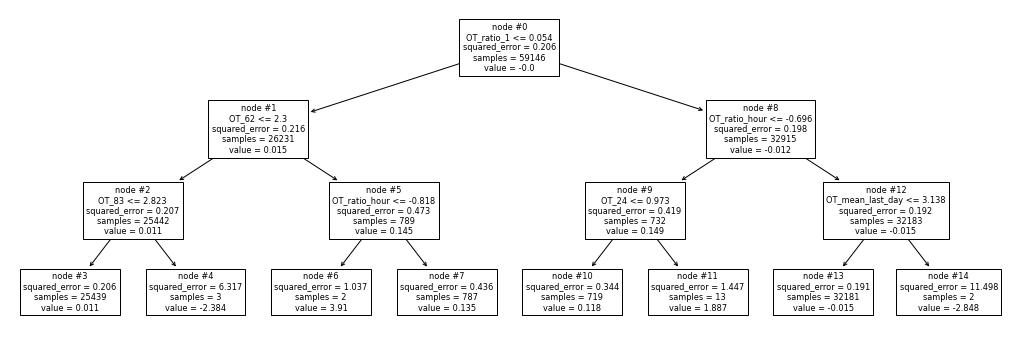

In [34]:
plt.figure(figsize=(18, 6))
plot_tree(error_trees[0], node_ids=True, feature_names=X_retrain.columns);

In [35]:
pred = np.abs(error_trees[0].predict(X_retrain_scaled))
worst_leaf = np.argmax(pred)
error_path = error_trees[0].decision_path(X_retrain_scaled[[worst_leaf]]).toarray()
indexes = np.where(error_path == 1)[1]

In [36]:
path1 = []
for i in indexes[:-1]:
    path1.append(str(X_retrain.columns[error_trees[0].tree_.feature[i]])+' <= '+str(error_trees[0].tree_.threshold[i]))
path1.append('leaf value: '+str(model._leaves[0]))

path1

['OT_ratio_1 <= 0.05392836220562458',
 'OT_62 <= 2.300433397293091',
 'OT_ratio_hour <= -0.8176020085811615',
 'leaf value: 3.9103593826293945']

The path followed is $True, False, True$. Thus, the new feature will assign $1$ to samples verifying that and $0$ to the rest.

In [37]:
pred_tree = np.abs(error_trees[0].predict(X_retrain_scaled.astype(np.float32), check_input=False))
pred_tree = (pred_tree == model._leaves[0]).astype(np.float32)
pred_tree = pred_tree.reshape(-1, 1)
X_trans = np.concatenate([X_retrain_scaled, pred_tree], axis=1)

#### New Feature 2

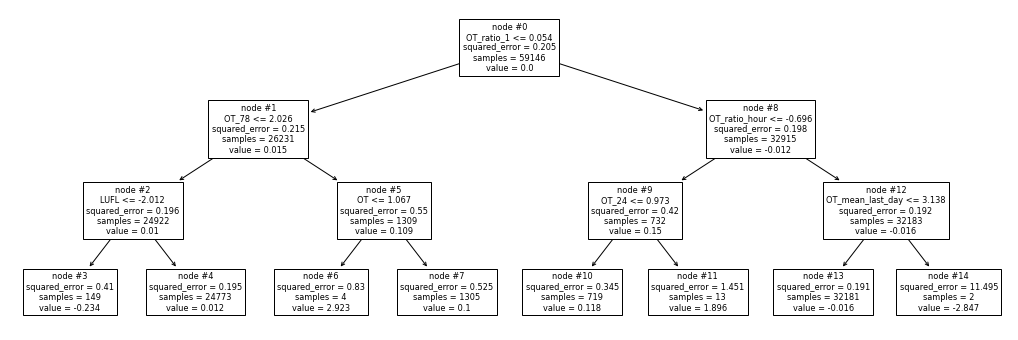

In [39]:
plt.figure(figsize=(18, 6))
plot_tree(error_trees[1], node_ids=True, feature_names=list(X_retrain.columns)+['New_Feature_1']);

In [40]:
pred = np.abs(error_trees[1].predict(X_trans))
worst_leaf = np.argmax(pred)
error_path = error_trees[1].decision_path(X_trans[[worst_leaf]]).toarray()
indexes = np.where(error_path == 1)[1]

In [41]:
path2 = []
for i in indexes[:-1]:
    path2.append(str(list(list(X_retrain.columns)+['New_Feature_1'])[error_trees[1].tree_.feature[i]])+' <= '+str(error_trees[1].tree_.threshold[i]))
path2.append('leaf value: '+str(model._leaves[1]))

path2

['OT_ratio_1 <= 0.05392836220562458',
 'OT_78 <= 2.0264207124710083',
 'OT <= 1.066814661026001',
 'leaf value: 2.9233398437500018']

The new variable assigns $1$ to samples that verify $True, False, True$.

In [42]:
pred_tree = np.abs(error_trees[1].predict(X_trans.astype(np.float32), check_input=False))
pred_tree = (pred_tree == model._leaves[1]).astype(np.float32)
pred_tree = pred_tree.reshape(-1, 1)
X_trans = np.concatenate([X_trans, pred_tree], axis=1)

#### New Feature 3

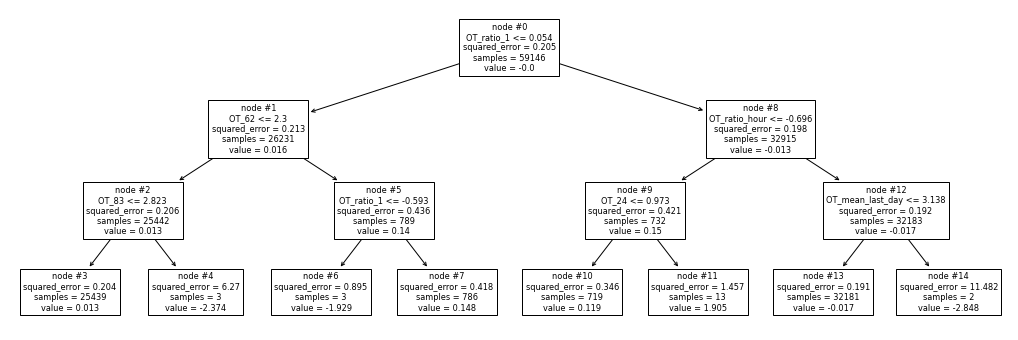

In [43]:
plt.figure(figsize=(18, 6))
plot_tree(error_trees[2], node_ids=True, feature_names=list(X_retrain.columns)+['New_Feature_1, New_Feature_2']);

In [44]:
pred = np.abs(error_trees[2].predict(X_trans))
worst_leaf = np.argmax(pred)
error_path = error_trees[2].decision_path(X_trans[[worst_leaf]]).toarray()
indexes = np.where(error_path == 1)[1]

In [45]:
path3 = []
for i in indexes[:-1]:
    path3.append(str(list(list(X_retrain.columns)+['New_Feature_1, New_Feature_2'])[error_trees[2].tree_.feature[i]])+' <= '+str(error_trees[2].tree_.threshold[i]))
path3.append('leaf value: '+str(model._leaves[2]))

path3

['OT_ratio_1 <= 0.05392836220562458',
 'OT_ratio_hour <= -0.6958335936069489',
 'OT_mean_last_day <= 3.138440728187561',
 'leaf value: 2.8479042053222656']

Samples that get 3 Falses in a row through that path will be codified as 1 in this new variable 

In [46]:
pred_tree = np.abs(error_trees[2].predict(X_trans.astype(np.float32), check_input=False))
pred_tree = (pred_tree == model._leaves[2]).astype(np.float32)
pred_tree = pred_tree.reshape(-1, 1)
X_trans = np.concatenate([X_trans, pred_tree], axis=1)

#### New Feature 4

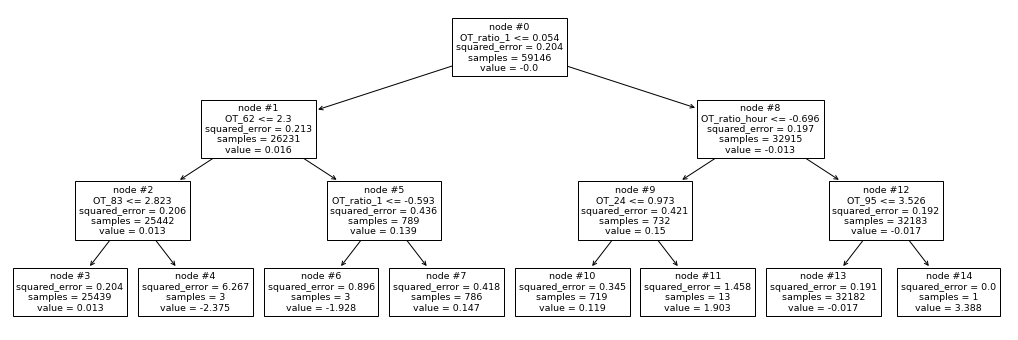

In [47]:
plt.figure(figsize=(18, 6))
plot_tree(error_trees[3], node_ids=True, feature_names=list(X_retrain.columns)+['New_Feature_1, New_Feature_2, New_Feature_3']);

In [48]:
pred = np.abs(error_trees[3].predict(X_trans))
worst_leaf = np.argmax(pred)
error_path = error_trees[3].decision_path(X_trans[[worst_leaf]]).toarray()
indexes = np.where(error_path == 1)[1]

In [49]:
path4 = []
for i in indexes[:-1]:
    path4.append(str(list(list(X_retrain.columns)+['New_Feature_1, New_Feature_2, New_Feature_3'])[error_trees[3].tree_.feature[i]])+' <= '+str(error_trees[3].tree_.threshold[i]))
path4.append('leaf value: '+str(model._leaves[3]))

path4

['OT_ratio_1 <= 0.05392836220562458',
 'OT_ratio_hour <= -0.6958335936069489',
 'OT_95 <= 3.5259467363357544',
 'leaf value: 3.3880538940429688']

Again, samples making 3 Falses in this path will be 1 in this new feature

In [50]:
pred_tree = np.abs(error_trees[3].predict(X_trans.astype(np.float32), check_input=False))
pred_tree = (pred_tree == model._leaves[3]).astype(np.float32)
pred_tree = pred_tree.reshape(-1, 1)
X_trans = np.concatenate([X_trans, pred_tree], axis=1)

#### New Feature 5

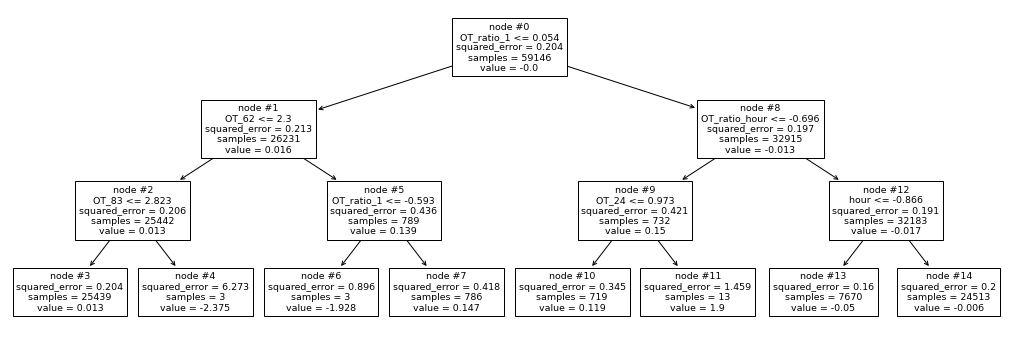

In [51]:
plt.figure(figsize=(18, 6))
plot_tree(error_trees[4], node_ids=True, feature_names=list(X_retrain.columns)+['New_Feature_1, New_Feature_2, New_Feature_3, New_Feature_4']);

In [52]:
pred = np.abs(error_trees[4].predict(X_trans))
worst_leaf = np.argmax(pred)
error_path = error_trees[4].decision_path(X_trans[[worst_leaf]]).toarray()
indexes = np.where(error_path == 1)[1]

path5 = []
for i in indexes[:-1]:
    path5.append(str(list(list(X_retrain.columns)+['New_Feature_1, New_Feature_2, New_Feature_3, New_Feature_4'])[error_trees[4].tree_.feature[i]])+' <= '+str(error_trees[4].tree_.threshold[i]))
path5.append('leaf value: '+str(model._leaves[4]))

path5

['OT_ratio_1 <= 0.05392836220562458',
 'OT_62 <= 2.300433397293091',
 'OT_83 <= 2.8234994411468506',
 'leaf value: 2.374881108601887']

This new feature assigns $1$ to the samples giving $True, True, False$ here. And we are done in this loop, now we look for the final linear model:

In [54]:
top_threshold = 5
top_coefficients = [coef for coef in model.base_estimator_.coef_.ravel() if abs(coef) > top_threshold]
top_features = [name for name, coef in zip(X_retrain.columns, model.base_estimator_.coef_.ravel()) if abs(coef) > top_threshold]

In [55]:
labels = [' ' if feature not in top_features else feature for feature in X_retrain.columns]+['New_Feature_1']+['New_Feature_2']+['New_Feature_3']+['New_Feature_4']+['New_Feature_5']

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_10876/3095631854.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90, ha='right')


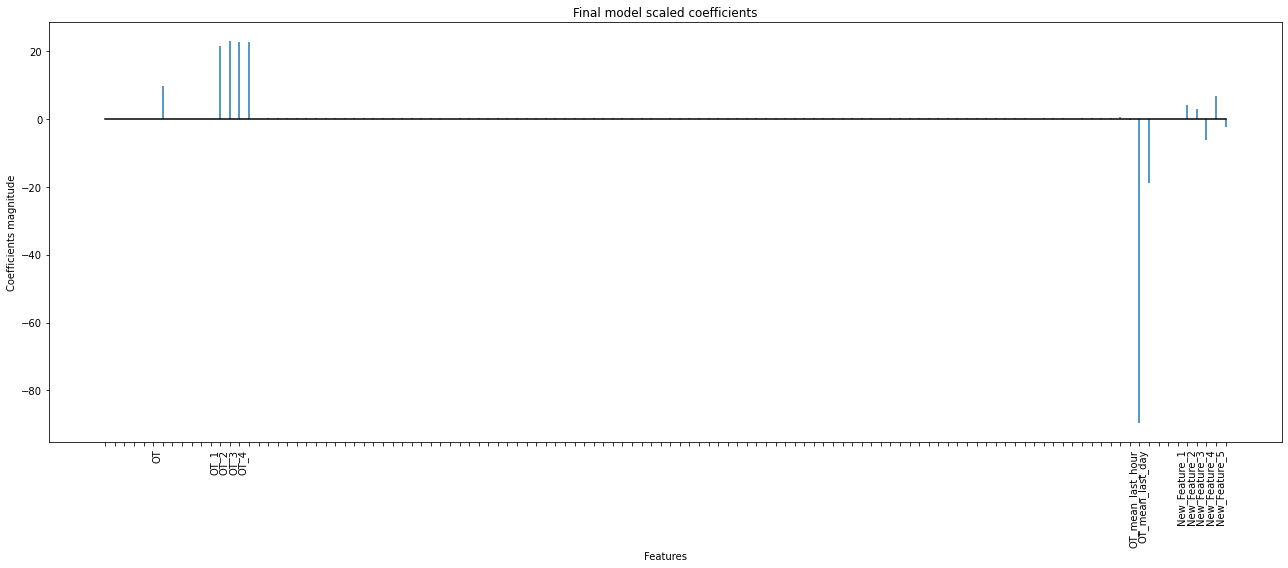

In [56]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.stem(list(list(X_retrain.columns)+['New_Feature_1']+['New_Feature_2']+['New_Feature_3']+['New_Feature_4']+['New_Feature_5']), model.base_estimator_.coef_.ravel(), markerfmt=' ', basefmt='k-')
ax.set_xlabel('Features')
ax.set_ylabel('Coefficients magnitude')
ax.set_title('Final model scaled coefficients')
ax.set_xticklabels(labels, rotation=90, ha='right')
plt.tight_layout()
plt.show()

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_10876/1387393881.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_retrain.min(), y_retrain.max()], [y_retrain.min(), y_retrain.max()],


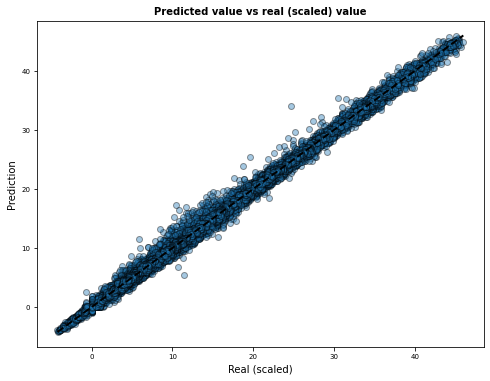

In [57]:
prediction_retrain = model.predict(X_retrain_scaled)
error_retrain   = prediction_retrain - y_retrain

plt.figure(figsize=(8, 6))

plt.scatter(y_retrain, prediction_retrain, edgecolors=(0, 0, 0), alpha = 0.4)
plt.plot([y_retrain.min(), y_retrain.max()], [y_retrain.min(), y_retrain.max()],
                'k--', color = 'black', lw=2)
plt.title('Predicted value vs real (scaled) value', fontsize = 10, fontweight = "bold")
plt.xlabel('Real (scaled)')
plt.ylabel('Prediction')
plt.tick_params(labelsize = 7)

In [13]:
from joblib import load
load_mod = load('../../../data/model_output/models/electricity_transformer/best_eblr.joblib')

train_pred = load_mod.predict(X_retrain_scaled)
rmse_train = root_mean_squared_error(y_retrain, train_pred)
test_pred = load_mod.predict(X_test_scaled)
rmse_test = root_mean_squared_error(y_test, test_pred)

In [14]:
import time 
time1 = time.time()
LinearBoostRegressor(base_estimator=LinearRegression(), max_depth=3, n_estimators=5).fit(X_retrain_scaled, y_retrain)
time2 = time.time() - time1 

with open('../../../data/model_output/metrics/electricity_transformer/final_metrics.txt', 'a') as f:
     f.write(f'\nEBLR; {time2}; {rmse_train}; {rmse_test}')